<a href="https://colab.research.google.com/github/cisco00/Bank-loan/blob/master/Loan_Risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [2]:
import warnings
warnings.simplefilter('ignore')

In [4]:
loan_risk = pd.read_csv("/content/risk_data.csv")
loan_risk

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,B
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,NaN,1736,12,furniture/equipment,G
996,40,male,3,own,little,little,3857,30,car,good
997,38,male,2,own,little,NaN,804,12,radio/TV,good
998,23,male,2,free,little,little,1845,45,radio/TV,bad


In [5]:
loan_risk.isna().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [6]:
clean_loan_data = loan_risk.fillna(0)
clean_loan_data 

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,0,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,B
2,49,male,1,own,little,0,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,0,1736,12,furniture/equipment,G
996,40,male,3,own,little,little,3857,30,car,good
997,38,male,2,own,little,0,804,12,radio/TV,good
998,23,male,2,free,little,little,1845,45,radio/TV,bad


In [7]:
clean_loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   1000 non-null   object
 5   Checking account  1000 non-null   object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.2+ KB


In [8]:
le = preprocessing.LabelEncoder()

In [9]:
clean_loan_data['Sex'] = le.fit_transform(clean_loan_data['Sex']) 
clean_loan_data['Saving accounts'] = le.fit_transform(clean_loan_data['Housing'])
clean_loan_data['Housing'] = le.fit_transform(clean_loan_data['Sex'])

In [10]:
clean_loan_data['target'] = clean_loan_data['Risk'].apply(lambda x: 0 if x == 'bad' else(0 if x == 'B' else 1))
clean_loan_data_ = clean_loan_data.drop(columns=['Risk'], axis=1)

Dropping features

In [11]:
clean_loan_data1 = clean_loan_data_.drop(['Checking account', 'Purpose'], axis=1)

In [12]:
clean_loan_data1.describe()

,Age,Sex,Job,Housing,Saving accounts,Credit amount,Duration,target
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000
mean,35.546000,0.690000,1.904000,0.690000,2.34200,3271.258000,20.903000,0.700000
std,11.375469,0.462725,0.653614,0.462725,1.16636,2822.736876,12.058814,0.458487
min,19.000000,0.000000,0.000000,0.000000,0.00000,250.000000,4.000000,0.000000
25%,27.000000,0.000000,2.000000,0.000000,2.00000,1365.500000,12.000000,0.000000
50%,33.000000,1.000000,2.000000,1.000000,2.00000,2319.500000,18.000000,1.000000
75%,42.000000,1.000000,2.000000,1.000000,3.00000,3972.250000,24.000000,1.000000
max,75.000000,1.000000,3.000000,1.000000,5.00000,18424.000000,72.000000,1.000000


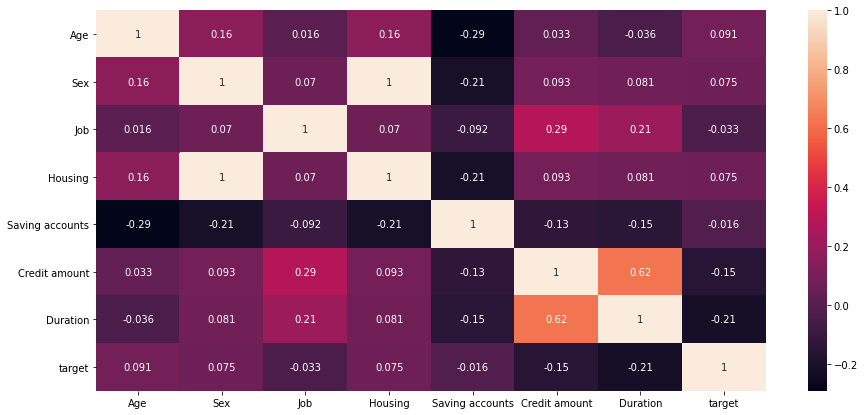

In [13]:
figure = plt.figure(figsize=(15, 7))

sns.heatmap(clean_loan_data1.corr(), annot=True)

In [14]:
X = clean_loan_data1.drop(columns=['target'], axis=1)
y = clean_loan_data1['target']

In [15]:
loan_dmatrix = xgb.DMatrix(data=X, label= y)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state = 70)

In [17]:
print(X_train.shape)
print(y_train.shape)

(800, 7)
(800,)


In [18]:
xg_reg = xgb.XGBRegressor(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.001,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [19]:
loan_xgb_model = xg_reg.fit(X_train, y_train)

y_pred = xg_reg.predict(X_test)

In [20]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

RMSE: 0.499106


Cross Validation

In [22]:
params = {"objective":"reg:logistic",'colsample_bytree': 0.3,'learning_rate': 0.01,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=loan_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

In [32]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.499266,0.000065,0.499270,0.000028
1,0.498458,0.000168,0.498505,0.000018
2,0.497622,0.000217,0.497690,0.000079
3,0.496805,0.000297,0.496890,0.000117
4,0.496016,0.000354,0.496123,0.000176


In [25]:
print(cv_results['test-rmse-mean'].tail(1))

49    0.472146
Name: test-rmse-mean, dtype: float64


In [26]:
xg_reg = xgb.train(params=params, dtrain=loan_dmatrix, num_boost_round=10)

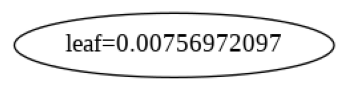

In [27]:
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

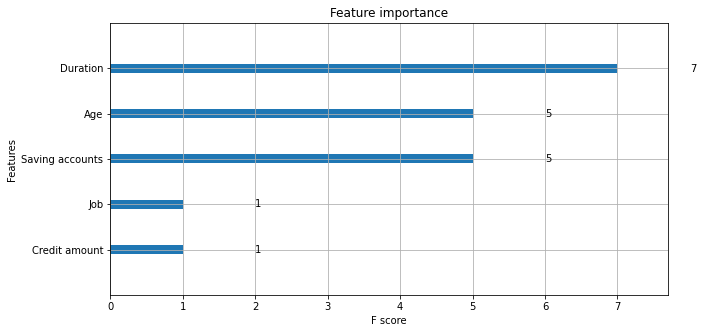

In [31]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

From thr graph above it shows that Financial institution who are into loan have to consider the above factor very well before given a loan to an individual most especially the duration of the loan.

END OF NOTEBOOK